In [12]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
#from transformers import AutoTokenizer
import tiktoken

from src.dataimport import list_files, list_files_with_extension, list_files_with_extension_directory, load_text
from src.llmlib import num_tokens_from_string

In [13]:
# Hilffunktionen
model_id = "gpt-4o-mini-2024-07-18"

# def calculate_token_count(text):
#     tokenizer = AutoTokenizer.from_pretrained(model_id)
#     tokenized_text = tokenizer(text, return_tensors="pt") # pt = PyTorch
#     return tokenized_text.input_ids.size()[1]


# Dateien laden

In [14]:
# Example usage
RAW_FILES_PATH = 'data/original/brat-project-final/'
TRANSFORMED_FILES_PATH = 'data/transformed/'
list_files(TRANSFORMED_FILES_PATH)[:7]

['essay001.ann',
 'essay001.json',
 'essay002.ann',
 'essay002.json',
 'essay003.ann',
 'essay003.json',
 'essay004.ann']

In [15]:
files_directory_txt = list_files_with_extension_directory(RAW_FILES_PATH, '.txt')
files_directory_ann = list_files_with_extension_directory(RAW_FILES_PATH, '.ann')
files_directory_json = list_files_with_extension_directory(TRANSFORMED_FILES_PATH, '.json')
print(files_directory_txt)
print(files_directory_ann)
print(files_directory_json)

['data/original/brat-project-final/essay001.txt', 'data/original/brat-project-final/essay002.txt', 'data/original/brat-project-final/essay003.txt', 'data/original/brat-project-final/essay004.txt', 'data/original/brat-project-final/essay005.txt', 'data/original/brat-project-final/essay006.txt', 'data/original/brat-project-final/essay007.txt', 'data/original/brat-project-final/essay008.txt', 'data/original/brat-project-final/essay009.txt', 'data/original/brat-project-final/essay010.txt', 'data/original/brat-project-final/essay011.txt', 'data/original/brat-project-final/essay012.txt', 'data/original/brat-project-final/essay013.txt', 'data/original/brat-project-final/essay014.txt', 'data/original/brat-project-final/essay015.txt', 'data/original/brat-project-final/essay016.txt', 'data/original/brat-project-final/essay017.txt', 'data/original/brat-project-final/essay018.txt', 'data/original/brat-project-final/essay019.txt', 'data/original/brat-project-final/essay020.txt', 'data/original/brat

In [16]:
print(len(files_directory_txt))
print(len(files_directory_ann))
print(len(files_directory_json))

402
402
402


# Analyse der Essays (TXT-Dateien)

In [17]:
def calculate_txt_file_lengths(files_path_list):
    """
    Calculate the number of characters and words in each text file in the given directory.
    """
    file_lengths = []

    for file_path in files_path_list:
        with open(file_path, 'r') as f:
            content = f.read()
            char_count = len(content) # count characters
            word_count = len(content.split()) # count words
            token_count = num_tokens_from_string(content, model_id) # count tokens
            file_lengths.append({'FileName': os.path.basename(file_path),
                                 'txt': content, 
                                 'CharCount': char_count,
                                 'WordCount': word_count,
                                 'TokenCount_txt': token_count})

    df_lengths = pd.DataFrame(file_lengths)
    return df_lengths

In [18]:
txt_lengths_df = calculate_txt_file_lengths(files_directory_txt)
txt_lengths_df

,FileName,txt,CharCount,WordCount,TokenCount_txt
0,essay001.txt,Should students be taught to compete or to coo...,2232,376,419
1,essay002.txt,More people are migrating to other countries t...,2078,333,374
2,essay003.txt,International tourism is now more common than ...,1789,260,303
3,essay004.txt,International tourism is now more common than ...,1884,288,328
4,essay005.txt,Living and studying overseas\n\nIt is every st...,1654,262,293
...,...,...,...,...,...
397,essay398.txt,We can not forcedly put the same numbers of ma...,1952,325,365
398,essay399.txt,"Drugs, alcohol and messy sex lives\n\nCelebrit...",1550,263,300
399,essay400.txt,A greater proportion of the budget should be a...,1813,284,304
400,essay401.txt,Fatherhood should be as present as motherhood ...,1669,280,320


In [26]:
duplicate_files = txt_lengths_df[txt_lengths_df.duplicated(subset=['txt'], keep=False)][['FileName', 'txt']]
duplicate_files

,FileName,txt
170,essay171.txt,A greater proportion of the budget should be a...
208,essay209.txt,University education restriction\n\nUniverstiy...
209,essay210.txt,A greater proportion of the budget should be a...
376,essay377.txt,University education restriction\n\nUniverstiy...
399,essay400.txt,A greater proportion of the budget should be a...


In [27]:
duplicate_files_list = duplicate_files['FileName'].tolist()
duplicate_files_list

['essay171.txt',
 'essay209.txt',
 'essay210.txt',
 'essay377.txt',
 'essay400.txt']

In [8]:
txt_lengths_df.describe()

,CharCount,WordCount,TokenCount_txt
count,402.000000,402.000000,402.000000
mean,1974.139303,327.151741,371.773632
std,321.283904,56.232190,63.534788
min,1243.000000,199.000000,225.000000
25%,1765.500000,288.250000,325.250000
50%,1939.000000,318.000000,360.500000
75%,2173.750000,357.750000,407.750000
max,2847.000000,504.000000,564.000000


In [11]:
from collections import defaultdict

def find_duplicate_texts(files_path_list):
    """
    Find duplicate texts in the given list of file paths.
    """
    content_dict = defaultdict(list)

    for file_path in files_path_list:
        with open(file_path, 'r') as f:
            content = f.read()
            content_dict[content].append(file_path)

    duplicates = {k: v for k, v in content_dict.items() if len(v) > 1}
    return duplicates

# Find duplicates in the text files
duplicates = find_duplicate_texts(files_directory_txt)

# Print the duplicate texts
if duplicates:
    print("Duplicate texts found:")
    for content, file_paths in duplicates.items():
        print(f"Content: {content[:100]}...")  # Print the first 100 characters of the content
        print("Files:")
        for file_path in file_paths:
            print(f"  - {file_path}")
else:
    print("All texts are unique.")

Duplicate texts found:
Content: A greater proportion of the budget should be allotted to education and prevention issues

In today's...
Files:
  - data/original/brat-project-final/essay171.txt
  - data/original/brat-project-final/essay210.txt
  - data/original/brat-project-final/essay400.txt
Content: University education restriction

Universtiy is an entrance to life. It equips us with a package of ...
Files:
  - data/original/brat-project-final/essay209.txt
  - data/original/brat-project-final/essay377.txt


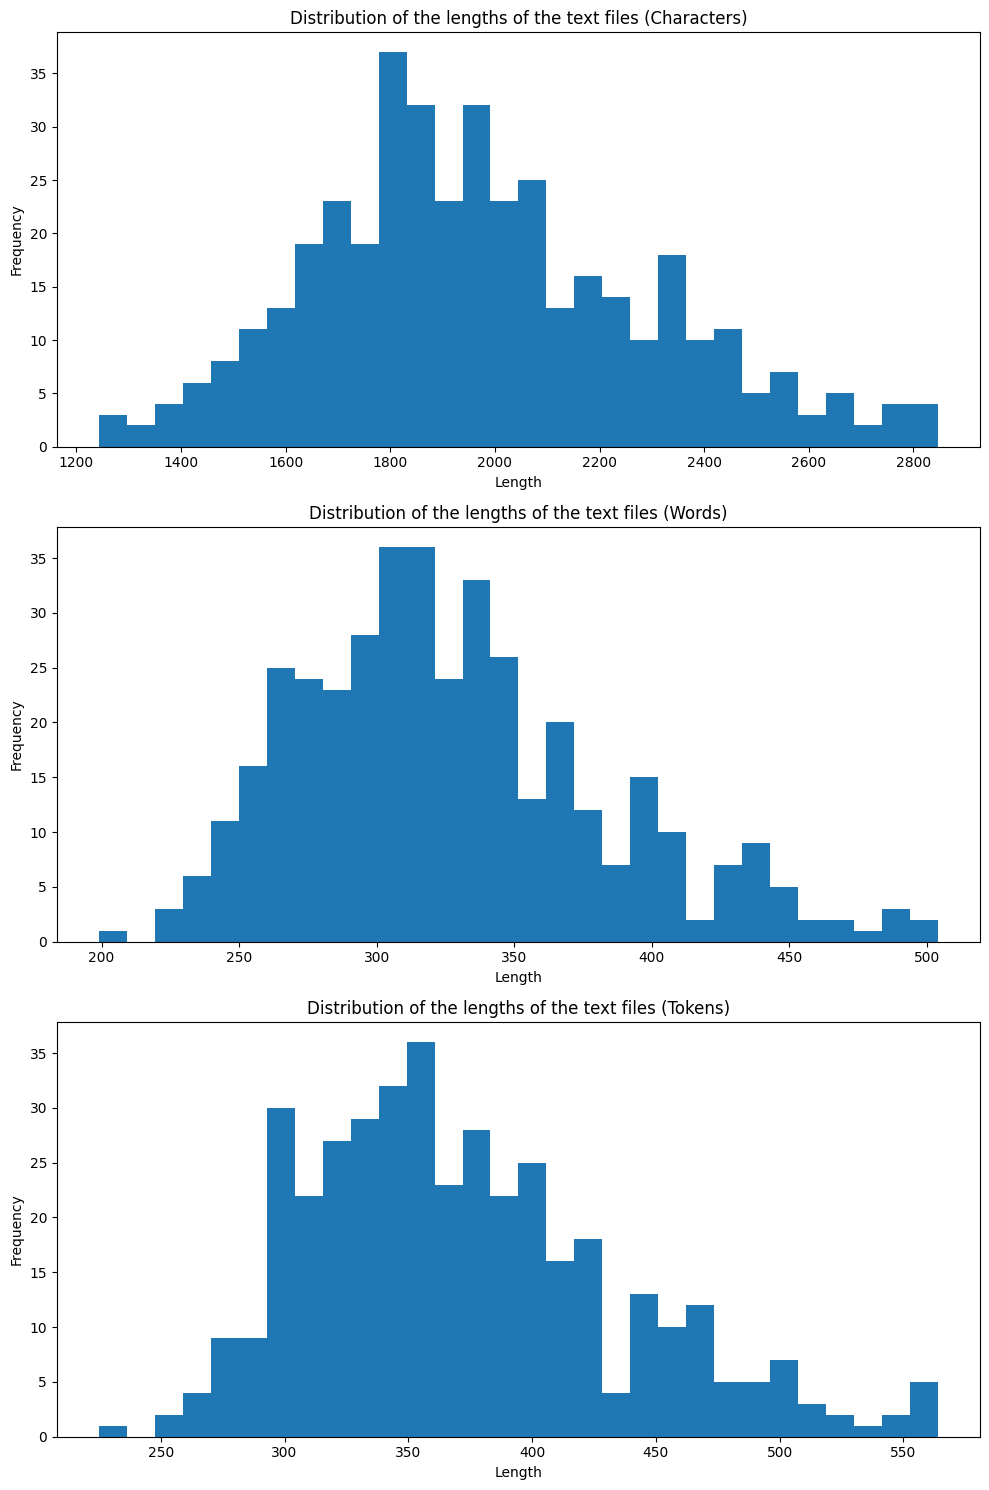

In [11]:
# distribution of the lengths of the text files
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Character count distribution
axs[0].hist(txt_lengths_df['CharCount'], bins=30)
axs[0].set_title('Distribution of the lengths of the text files (Characters)')
axs[0].set_xlabel('Length')
axs[0].set_ylabel('Frequency')

# Word count distribution
axs[1].hist(txt_lengths_df['WordCount'], bins=30)
axs[1].set_title('Distribution of the lengths of the text files (Words)')
axs[1].set_xlabel('Length')
axs[1].set_ylabel('Frequency')

# Token count distribution
axs[2].hist(txt_lengths_df['TokenCount_txt'], bins=30)
axs[2].set_title('Distribution of the lengths of the text files (Tokens)')
axs[2].set_xlabel('Length')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

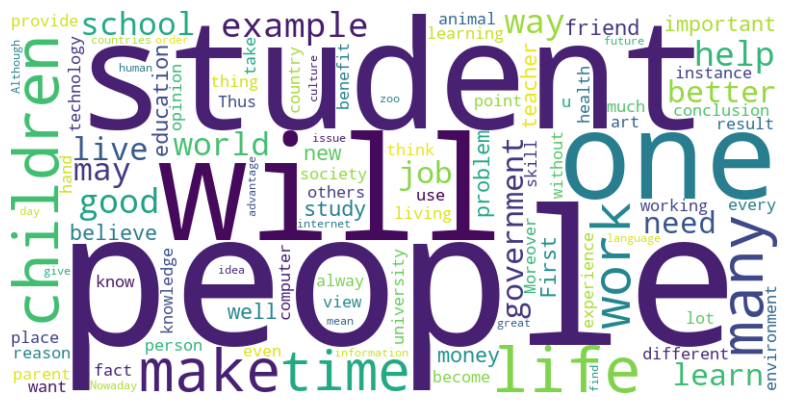

In [12]:
# Combine all text files into a single string
all_text = ''
for file_path in files_directory_txt:
    with open(file_path, 'r') as file:
        all_text += file.read() + ' '
# stopwords
stopwords = set(STOPWORDS)
# stopwords.update(['word1','word2'])

# Generate the word cloud
wordcloud = WordCloud(width=800,
                      height=400,
                      stopwords=stopwords,
                      background_color='white',
                      max_words=100, # default: 200
                      random_state=42
                      ).generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear') # bilinear interpolation to make the displayed image appear more smoothly
plt.axis('off')
#plt.title('Word Cloud for Text Files')
plt.show()

# save to file
# wordcloud.to_file('wordcloud.png')

# Quelle für Wordcloud: https://www.datacamp.com/tutorial/wordcloud-python

# Analyse der Annotationen (ANN-Dateien )

In [18]:
#Beispiel für ANN-Datei
print(load_text(files_directory_ann[0]))

T1	MajorClaim 503 575	we should attach more importance to cooperation during primary education
T2	MajorClaim 2154 2231	a more cooperative attitudes towards life is more profitable in one's success
T3	Claim 591 714	through cooperation, children can learn about interpersonal skills which are significant in the future life of all students
A1	Stance T3 For
T4	Premise 716 851	What we acquired from team work is not only how to achieve the same goal with others but more importantly, how to get along with others
T5	Premise 853 1086	During the process of cooperation, children can learn about how to listen to opinions of others, how to communicate with others, how to think comprehensively, and even how to compromise with other team members when conflicts occurred
T6	Premise 1088 1191	All of these skills help them to get on well with other people and will benefit them for the whole life
R1	supports Arg1:T4 Arg2:T3	
R2	supports Arg1:T5 Arg2:T3	
R3	supports Arg1:T6 Arg2:T3	
T7	Claim 1332 1376	compe

## Anzahl MajorClaims, Claims, Premissen und Beziehungen zählen

In [15]:
def count_entities(files_list):
    data = []
    for file_path in files_list:
        file_name = os.path.basename(file_path)
        majorclaims = 0
        claims = 0
        premises = 0
        stances = 0
        relation = 0
        with open(file_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                if line.startswith('T'):
                    entity = line.split('\t')[1].split(' ')[0]
                    if entity == 'MajorClaim':
                        majorclaims += 1
                    elif entity == 'Claim':
                        claims += 1
                    elif entity == 'Premise':
                        premises += 1
                elif line.startswith('A'):
                    entity = line.split('\t')[1].split(' ')[0]
                    if entity == 'Stance':
                        stances += 1
                elif line.startswith('R'):
                    relation += 1
            token_count = num_tokens_from_string(' '.join(lines), model_id)

        data.append({'FileName': file_name,
                     'MajorClaims': majorclaims,
                     'Claims': claims,
                     'Premises': premises,
                     'Stances': stances,
                     'Relations': relation,
                     'Total': majorclaims + claims + premises + stances + relation,
                     'TokenCount_ann': token_count})
    
    df = pd.DataFrame(data)
    
    return df

In [16]:
count_df = count_entities(files_directory_ann)

# sort the files by the number of entities
count_df = count_df.sort_values(by=['Total'], ascending=False)
count_df

CPU times: total: 109 ms
Wall time: 984 ms


,FileName,MajorClaims,Claims,Premises,Stances,Relations,Total,TokenCount_ann
168,essay169.ann,2,6,20,6,20,54,1044
160,essay161.ann,2,8,16,8,16,50,980
153,essay154.ann,2,6,18,6,18,50,987
285,essay286.ann,2,5,18,5,18,48,913
311,essay312.ann,2,4,19,4,19,48,886
...,...,...,...,...,...,...,...,...
102,essay103.ann,1,3,4,3,4,15,358
32,essay033.ann,1,3,4,3,4,15,328
139,essay140.ann,2,2,4,2,4,14,384
170,essay171.ann,2,2,4,2,4,14,354


In [17]:
count_df.describe()

,MajorClaims,Claims,Premises,Stances,Relations,Total,TokenCount_ann
count,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000
mean,1.868159,3.746269,9.532338,3.746269,9.532338,28.425373,593.925373
std,0.452239,1.158423,3.405321,1.158423,3.405321,7.780701,140.771067
min,1.000000,2.000000,2.000000,2.000000,2.000000,12.000000,291.000000
25%,2.000000,3.000000,7.000000,3.000000,7.000000,22.000000,491.000000
50%,2.000000,4.000000,9.000000,4.000000,9.000000,28.000000,578.500000
75%,2.000000,4.000000,12.000000,4.000000,12.000000,34.000000,691.000000
max,3.000000,10.000000,20.000000,10.000000,20.000000,54.000000,1044.000000


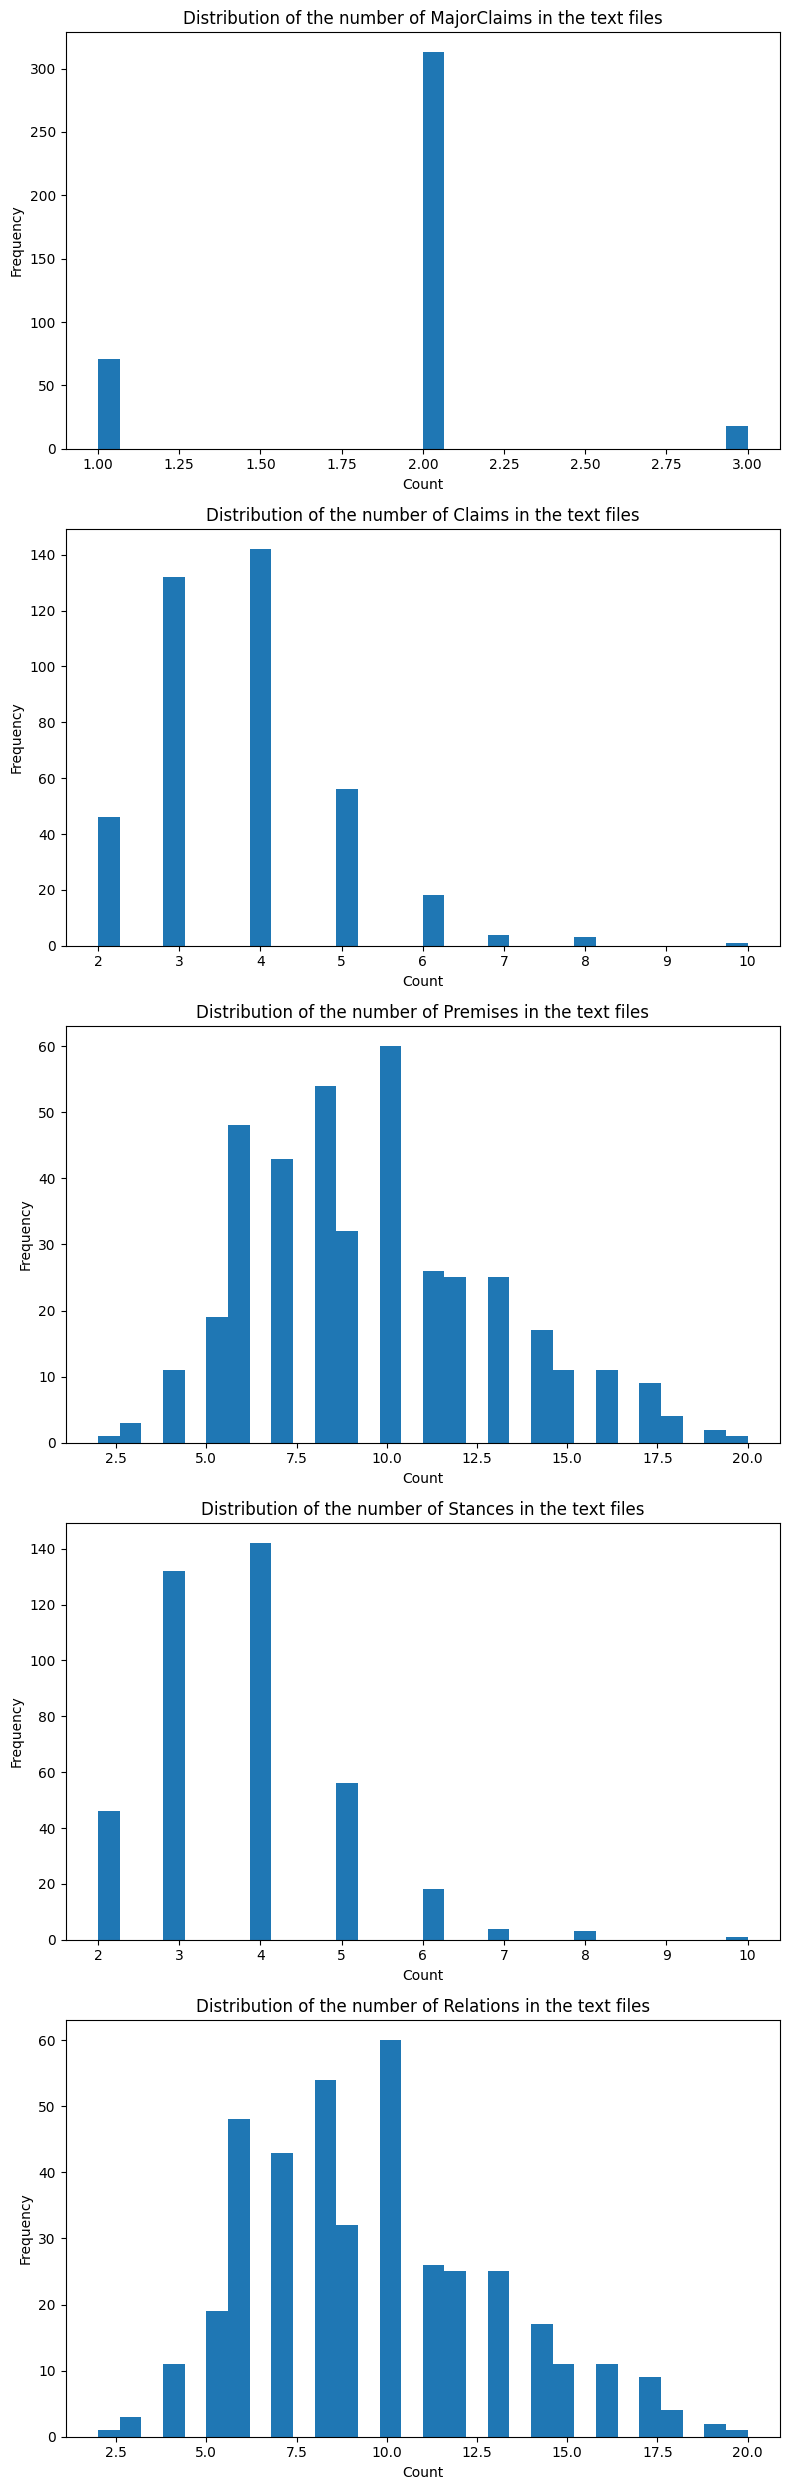

In [18]:
# distribution of the number of entities in the text files
fig, axs = plt.subplots(5, 1, figsize=(8, 25))

# MajorClaims count distribution
axs[0].hist(count_df['MajorClaims'], bins=30)
axs[0].set_title('Distribution of the number of MajorClaims in the text files')
axs[0].set_xlabel('Count')
axs[0].set_ylabel('Frequency')

# Claims count distribution
axs[1].hist(count_df['Claims'], bins=30)
axs[1].set_title('Distribution of the number of Claims in the text files')
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Frequency')

# Premises count distribution
axs[2].hist(count_df['Premises'], bins=30)
axs[2].set_title('Distribution of the number of Premises in the text files')
axs[2].set_xlabel('Count')
axs[2].set_ylabel('Frequency')

# Stances count distribution
axs[3].hist(count_df['Stances'], bins=30)
axs[3].set_title('Distribution of the number of Stances in the text files')
axs[3].set_xlabel('Count')
axs[3].set_ylabel('Frequency')

# Relations count distribution
axs[4].hist(count_df['Relations'], bins=30)
axs[4].set_title('Distribution of the number of Relations in the text files')
axs[4].set_xlabel('Count')
axs[4].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# # distribution of the total number of entities in the text files
# plt.hist(count_df['Total'], bins=30)
# plt.title('Distribution of the total number of entities in the text files')
# plt.xlabel('Count')
# plt.ylabel('Frequency')
# plt.show()

# # distribution of the token count in the text files
# plt.hist(count_df['TokenCount'], bins=30)
# plt.title('Distribution of the token count in the text files')
# plt.xlabel('Count')
# plt.ylabel('Frequency')
# plt.show()

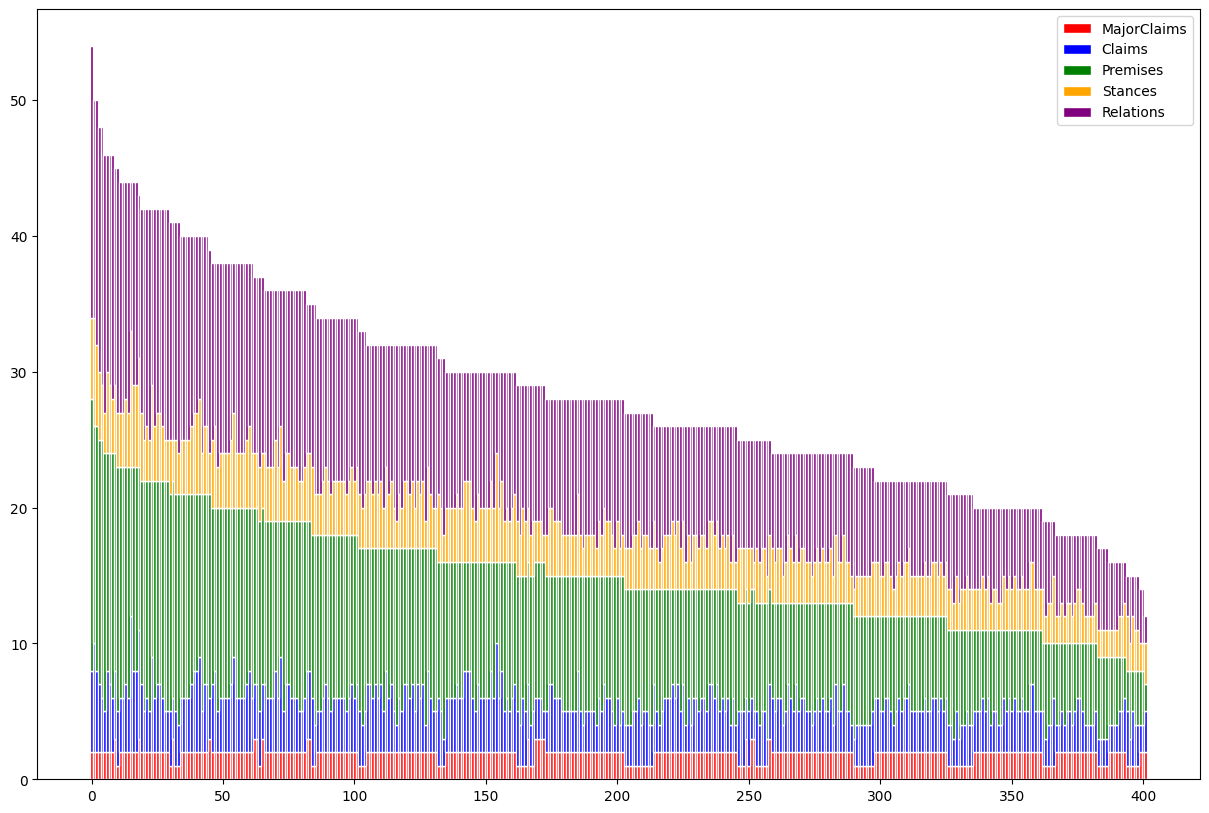

In [22]:
# plot stacked bar chart for the number of entities in each file
fig, ax = plt.subplots(figsize=(15, 10))

barWidth = 1
r = range(len(count_df))

plt.bar(r, count_df['MajorClaims'], color='red', edgecolor='white', width=barWidth, label='MajorClaims')
plt.bar(r, count_df['Claims'], bottom=count_df['MajorClaims'], color='blue', edgecolor='white', width=barWidth, label='Claims')
plt.bar(r, count_df['Premises'], bottom=count_df['MajorClaims'] + count_df['Claims'], color='green', edgecolor='white', width=barWidth, label='Premises')
plt.bar(r, count_df['Stances'], bottom=count_df['MajorClaims'] + count_df['Claims'] + count_df['Premises'], color='orange', edgecolor='white', width=barWidth, label='Stances')
plt.bar(r, count_df['Relations'], bottom=count_df['MajorClaims'] + count_df['Claims'] + count_df['Premises'] + count_df['Stances'], color='purple', edgecolor='white', width=barWidth, label='Relations')
plt.legend()


# Essays with annotations (TXT- und ANN-Dateien)

In [23]:
# combine the text and annotation dataframes using the file name without the extension
txt_lengths_df['FileName'] = txt_lengths_df['FileName'].str.replace('.txt', '')
count_df['FileName'] = count_df['FileName'].str.replace('.ann', '')

combined_df = pd.merge(left=txt_lengths_df, right=count_df, on='FileName')
combined_df['TokenCount_sum'] = combined_df['TokenCount_txt'] + combined_df['TokenCount_ann']
combined_df

,FileName,CharCount,WordCount,TokenCount_txt,MajorClaims,Claims,Premises,Stances,Relations,Total,TokenCount_ann,TokenCount_sum
0,essay001,2232,376,419,2,3,6,3,6,20,486,905
1,essay002,2078,333,374,2,3,9,3,9,26,582,956
2,essay003,1789,260,303,2,2,6,2,6,18,421,724
3,essay004,1884,288,328,2,3,6,3,6,20,461,789
4,essay005,1654,262,293,2,4,6,4,6,22,474,767
...,...,...,...,...,...,...,...,...,...,...,...,...
397,essay398,1952,325,365,1,4,11,4,11,31,647,1012
398,essay399,1550,263,300,2,3,5,3,5,18,379,679
399,essay400,1813,284,304,2,2,6,2,6,18,444,748
400,essay401,1669,280,320,2,2,6,2,6,18,439,759


In [31]:
combined_df[['TokenCount_txt', 'TokenCount_ann', 'TokenCount_sum']].describe()

,TokenCount_txt,TokenCount_ann,TokenCount_sum
count,402.000000,402.000000,402.000000
mean,371.773632,593.925373,965.699005
std,63.534788,140.771067,193.582427
min,225.000000,291.000000,554.000000
25%,325.250000,491.000000,820.250000
50%,360.500000,578.500000,942.000000
75%,407.750000,691.000000,1088.750000
max,564.000000,1044.000000,1506.000000


In [25]:
# 10 files with the smallest token count
smalest_10_token_sum = combined_df.nsmallest(10, 'TokenCount_sum')
smalest_10_token_sum

,FileName,CharCount,WordCount,TokenCount_txt,MajorClaims,Claims,Premises,Stances,Relations,Total,TokenCount_ann,TokenCount_sum
87,essay088,1329,233,263,2,3,2,3,2,12,291,554
395,essay396,1275,199,225,2,2,5,2,5,16,343,568
334,essay335,1429,227,267,1,4,3,4,3,15,305,572
32,essay033,1554,244,266,1,3,4,3,4,15,328,594
382,essay383,1761,253,288,1,4,3,4,3,15,322,610
120,essay121,1309,223,249,2,4,3,4,3,16,365,614
237,essay238,1289,223,249,2,4,4,4,4,18,380,629
371,essay372,1514,241,275,2,3,4,3,4,16,364,639
122,essay123,1381,239,268,2,2,7,2,7,20,379,647
367,essay368,1688,261,302,2,2,5,2,5,16,345,647


In [26]:
print(f"Die 10 Dateien mit der geringsten Tokenanzahl haben insgesamt {smalest_10_token_sum['TokenCount_sum'].sum()} Tokens.")
print(f"Davon entfallen {smalest_10_token_sum['TokenCount_txt'].sum()} Tokens auf die Textdateien und {smalest_10_token_sum['TokenCount_ann'].sum()} Tokens auf die Annotationsdateien.")

Die 10 Dateien mit der geringsten Tokenanzahl haben insgesamt 6074 Tokens.
Davon entfallen 2652 Tokens auf die Textdateien und 3422 Tokens auf die Annotationsdateien.


Das Tokenfenster von Llama 3.2 über die Huggingface API ist auf 4096 Token begrenzt. Daher muss die Summer der Input-Token und Output-Token kleiner als die Grenze sein. Bspw. indem man die Anzahl der Beispiele reduziert oder sich nur auf die Annotationen konzentriert.

Nachfolgend werden die Tokenanzahlen der Texte und Annotationen einzeln betrachtet.

In [27]:
smalest_10_token_txt = combined_df.nsmallest(10, 'TokenCount_txt')
smalest_10_token_txt

,FileName,CharCount,WordCount,TokenCount_txt,MajorClaims,Claims,Premises,Stances,Relations,Total,TokenCount_ann,TokenCount_sum
395,essay396,1275,199,225,2,2,5,2,5,16,343,568
120,essay121,1309,223,249,2,4,3,4,3,16,365,614
237,essay238,1289,223,249,2,4,4,4,4,18,380,629
87,essay088,1329,233,263,2,3,2,3,2,12,291,554
32,essay033,1554,244,266,1,3,4,3,4,15,328,594
334,essay335,1429,227,267,1,4,3,4,3,15,305,572
122,essay123,1381,239,268,2,2,7,2,7,20,379,647
74,essay075,1446,244,271,2,4,5,4,5,20,456,727
88,essay089,1453,239,272,2,6,8,6,8,30,528,800
387,essay388,1414,238,273,2,4,6,4,6,22,410,683


In [28]:
print(f"Die 10 Dateien mit der geringsten Tokenanzahl in den Textdateien haben insgesamt {smalest_10_token_txt['TokenCount_txt'].sum()} Tokens.")

Die 10 Dateien mit der geringsten Tokenanzahl in den Textdateien haben insgesamt 2603 Tokens.


In [29]:
smalest_10_tokenann = combined_df.nsmallest(10, 'TokenCount_ann')
smalest_10_tokenann

,FileName,CharCount,WordCount,TokenCount_txt,MajorClaims,Claims,Premises,Stances,Relations,Total,TokenCount_ann,TokenCount_sum
87,essay088,1329,233,263,2,3,2,3,2,12,291,554
334,essay335,1429,227,267,1,4,3,4,3,15,305,572
382,essay383,1761,253,288,1,4,3,4,3,15,322,610
32,essay033,1554,244,266,1,3,4,3,4,15,328,594
45,essay046,1925,310,348,1,2,5,2,5,15,340,688
395,essay396,1275,199,225,2,2,5,2,5,16,343,568
367,essay368,1688,261,302,2,2,5,2,5,16,345,647
70,essay071,1677,266,304,2,3,4,3,4,16,348,652
170,essay171,1813,284,304,2,2,4,2,4,14,354,658
102,essay103,1604,262,295,1,3,4,3,4,15,358,653


In [30]:
print(f"Die 10 Dateien mit der geringsten Tokenanzahl in den Annotationsdateien haben insgesamt {smalest_10_tokenann['TokenCount_ann'].sum()} Tokens.")

Die 10 Dateien mit der geringsten Tokenanzahl in den Annotationsdateien haben insgesamt 3334 Tokens.
